# Data Preparation

In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [173]:
def read_and_set_df(filepath: str, train: bool) -> pd.DataFrame:

    # with open(filepath) as file:
    # file.readlines()

    # Datensatz einlesen
    df = pd.read_csv(filepath, sep='$',  # r'([$-,])+/g'
                     decimal=".", engine='python')  # , na_values=[np.nan, pd.NA], keep_default_na=True)

    # Spaltennamen alle kleingeschrieben
    df.columns = df.columns.str.lower()

    # Die Spaltennamen waren verschoben - In diesem Schritt werden sie richtig zugeordnet
    df.rename(columns={
        'unnamed: 0': 'id',
        'id': 'gender',
        'gender': 'age',
        'age': 'driving_license',
        'driving_license': 'region_code',
        'region_code': 'previously_insured',
        'previously_insured': 'vehicle_age',
        'vehicle_age': 'vehicle_damage',
        'vehicle_damage': 'annual_premium',
        'annual_premium': 'policy_sales_channel',
        'policy_sales_channel': 'vintage',
        'vintage': 'response',
        'response': 'nan'
    },
        inplace=True)

    # Letzte Spalte besteht nur aus nan und kann somit gelöscht werden
    if not train:
        del df['nan']

    return df


def set_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    # Numerische Variablen
    # Nullable Interger

    # Variable Age
    df["age"] = df["age"].astype(str)
    df["age"] = df["age"].str.rstrip('.')
    df['age'] = df["age"].replace('nan', np.nan)
    df['age'] = pd.to_numeric(df['age'], errors='raise')
    df["age"] = df["age"].astype('Int64')

    # Annual Premium
    df['annual_premium'] = df['annual_premium'].astype(str)
    df['annual_premium'] = df['annual_premium'].str.rstrip('.')
    df["annual_premium"] = pd.to_numeric(df["annual_premium"], errors='raise')
    df["annual_premium"] = df["annual_premium"].astype('Int64')

    # Vintage
    df['vintage'] = df['vintage'].astype(str)
    df['vintage'] = df['vintage'].str.rstrip('##')
    df['vintage'] = df["vintage"].replace('nan', np.nan)
    df["vintage"] = pd.to_numeric(df["vintage"], errors='raise')
    df["vintage"] = df["vintage"].astype('Int64')

    # Region Code
    df['region_code'] = df['region_code'].astype(str)
    df['region_code'] = df['region_code'].str.rstrip('#')
    df["region_code"] = pd.to_numeric(df["region_code"], errors='raise')
    df['region_code'] = df['region_code'].astype('category')

    # Policy Sales Channel
    df['policy_sales_channel'] = df['policy_sales_channel'].astype(str)
    df['policy_sales_channel'] = df['policy_sales_channel'].str.rstrip('##')
    df["policy_sales_channel"] = pd.to_numeric(
        df["policy_sales_channel"], errors='raise')
    df["policy_sales_channel"] = df["policy_sales_channel"].astype('Int64')

    # Kategorische Variablen
    df['gender'] = df['gender'].astype('category')
    df['driving_license'] = df['driving_license'].astype('category')
    df['previously_insured'] = df['previously_insured'].astype('category')
    df['vehicle_damage'] = df['vehicle_damage'].astype('category')
    df['vehicle_age'] = df['vehicle_age'].astype('category')

    # Response
    df.response.replace(
        {'0': 'no', '1': 'yes', 1: 'yes', 0: 'no'}, inplace=True)
    df['response'] = df['response'].astype('category')

    #df = df.replace(to_replace=['NaN', '<NA>', 'NAN', 'nan',
    #                pd.NA, np.nan, np.NaN, np.NAN], value=np.NaN, inplace=True)

    return df

In [174]:
df = read_and_set_df('../data/train.csv', train=False)

set_datatypes(df)

df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,No,28.0,No,> 2 Years,Yes,40454,26,217,yes
1,2,Male,76,No,3.0,No,1-2 Year,No,33536,26,183,no
2,3,Male,47,No,28.0,No,> 2 Years,Yes,38294,26,27,yes
3,4,Male,21,Yes,11.0,Yes,< 1 Year,No,28619,152,203,no
4,5,Female,29,Yes,41.0,Yes,< 1 Year,No,27496,152,39,no


In [175]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,380999.0,NaN,NaN,NaN,190500.0,109985.081943,1.0,95250.5,190500.0,285749.5,380999.0
gender,379948,2,Male,205447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,370107.0,NaN,NaN,NaN,38.852091,15.63218,20.0,25.0,36.0,49.0,205.0
driving_license,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_code,380999.0,53.0,28.0,106372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previously_insured,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_age,380948,3,1-2 Year,200228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_damage,380948,2,Yes,192328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_premium,380999.0,NaN,NaN,NaN,30527.70069,17242.997675,-9997.0,24371.0,31656.0,39390.0,540165.0
policy_sales_channel,380999.0,NaN,NaN,NaN,112.035331,54.203334,1.0,29.0,133.0,152.0,163.0


## Missing Values

Die Funktion `heatmap()` von `missingno` misst die Nullkorrelation: wie stark das Vorhandensein oder Fehlen einer Variable das Vorhandensein einer anderen Variable beeinflusst.

Die Nullkorrelation reicht von -1 (wenn eine Variable auftritt, tritt die andere definitiv nicht auf) über 0 (auftauchende oder nicht auftauchende Variablen haben keinen Einfluss aufeinander) bis 1 (wenn eine Variable auftritt, tritt die andere definitiv auf).


### Verteilung der Missing Values 

<AxesSubplot:>

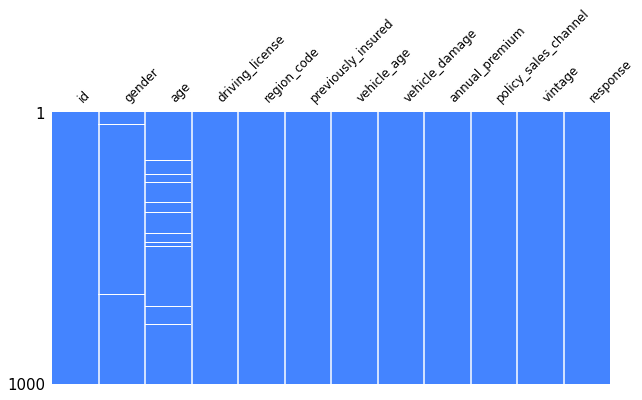

In [176]:
# Verteilung der Missing Values innerhalb der Variablen 
msno.matrix(df.sample(1000), sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

<AxesSubplot:>

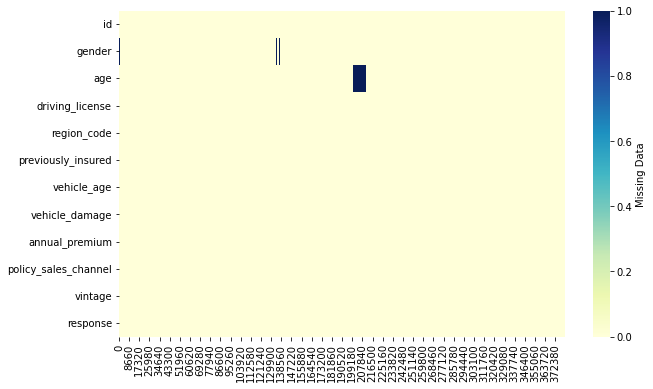

In [177]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

<AxesSubplot:>

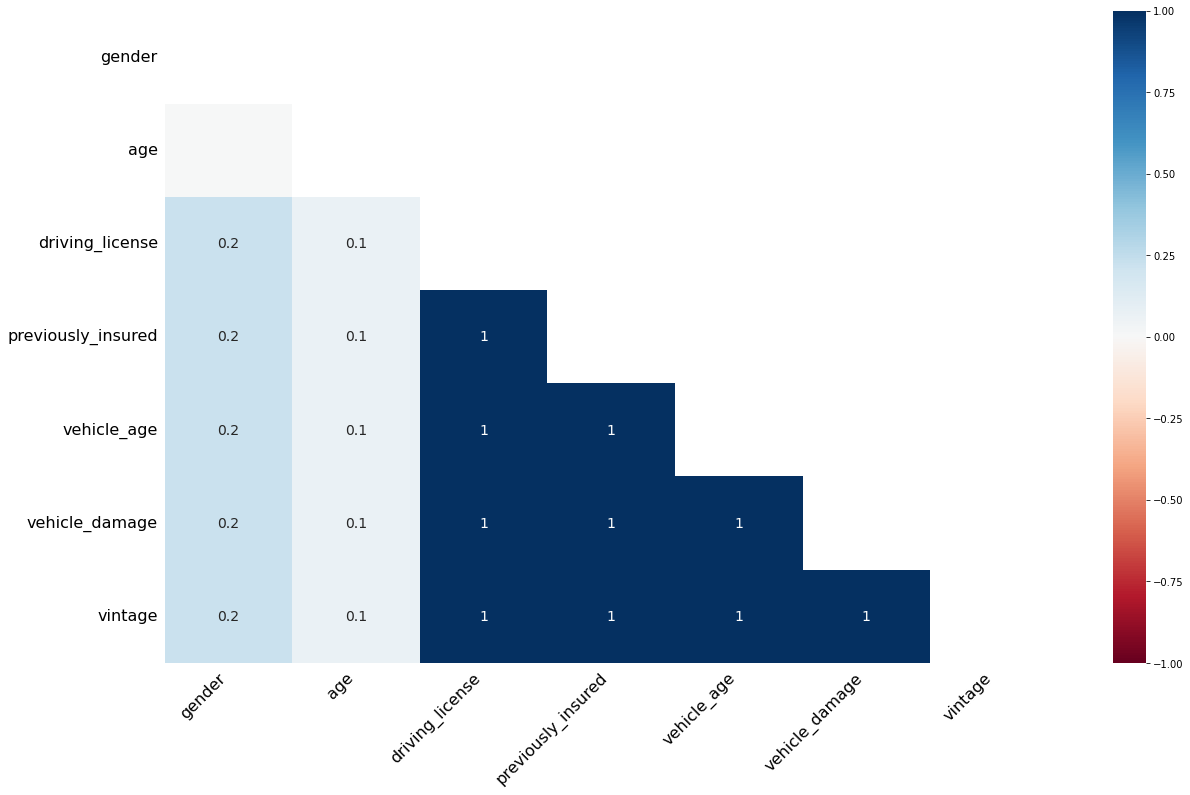

In [178]:
# Lineare Abhängigkeit der fehlenden Werten in den jeweiligen Spalten 
# -> Zeigt an, ob fehlende Werte an denselben Stellen in Datensatz auftreten
msno.heatmap(df)

Um dieses Diagramm zu interpretieren, lesen Sie es aus einer Top-Down-Perspektive. Clusterblätter, die in einem Abstand von Null miteinander verbunden sind, sagen das Vorhandensein des jeweils anderen vollständig voraus - eine Variable könnte immer leer sein, wenn eine andere gefüllt ist, oder sie könnten immer beide gefüllt oder beide leer sein, und so weiter. In diesem speziellen Beispiel klebt das Dendrogramm die Variablen zusammen, die erforderlich und daher in jedem Datensatz vorhanden sind.

Beschreibung: 
Das Dendrogramm verwendet einen hierarchischen Clustering-Algorithmus, um die Variablen anhand ihrer Nullkorrelation gegeneinander abzugrenzen. 

Erklärung: 
Clutster, die sich in bei Null aufspalten, sagen sich untereinander vollkommen voraus (Korrelation von 1). 

Auf jeder Stufe des Baums werden die Variablen auf der Grundlage der Kombination aufgeteilt, die den Abstand der verbleibenden Cluster minimiert.  

Je monotoner die Variablen sind, desto näher liegt ihr Gesamtabstand bei Null und desto näher liegt ihr durchschnittlicher Abstand (die y-Achse) bei Null.   

<AxesSubplot:>

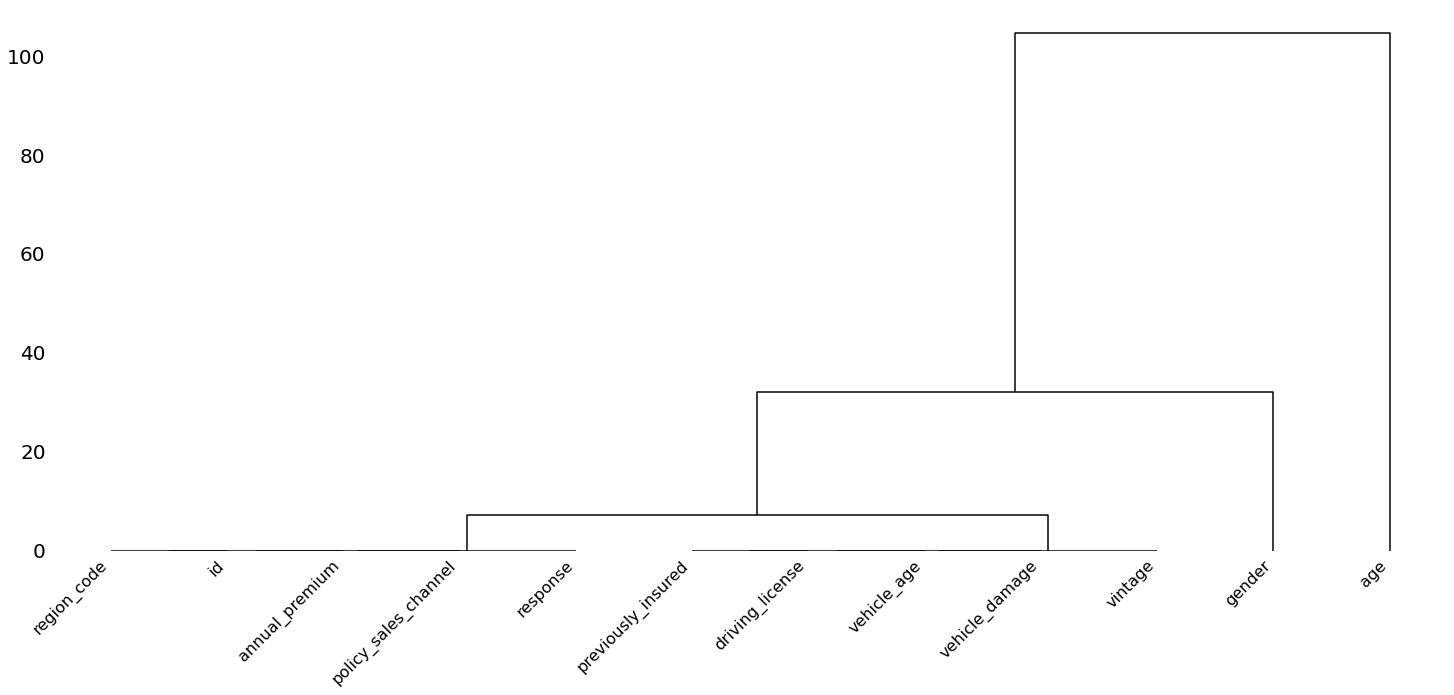

In [179]:
msno.dendrogram(df, orientation='top')

In [247]:
df_na_bool = pd.DataFrame(pd.isna(df))

df.drop(df_na_bool[(df_na_bool['previously_insured'] == True) & 
           (df_na_bool['driving_license'] == True) &
           (df_na_bool['vehicle_age'] == True) &
           (df_na_bool['vehicle_damage'] == True) &
           (df_na_bool['vintage'] == True)].index, inplace=True)

Listenweiser Fallausschluss - Wir haben mittels dem listenweisen Fallausschluss 51 Zeilen aus dem Datensatz entfernt. Dabei haben wir ebenfalls die Anzahl der missing values bei den Variablen von age und gender um 51 Werte reduziert.

## Behandlung von Anomalien

### Age

- Untergrenze: 18 

Da man in Indien ab 18 Jahren ein KFZ  führen darf, kann man ab diesem Alter auch auf seinen Namen eine KFZ-Verischerung abschließen
- Obergrenze: 75

Da der obere Whisker bei `age` und `response=Yes` bei 75 liegt, übernehmen wir diesen Wert als Übergrenze. 
Aufgrund der durchschnittlichen Lebenserwartung in Indien von 69.3, wird es wohl keine Personen über 80 Jahren geben, welche noch ein KFZ führen.

In [248]:
index_max_age = df[df["age"] >= 75].index
df.drop(index_max_age, inplace=True)

index_min_age = df[df["age"] < 18].index
df.drop(index_min_age, inplace=True)

df["age"].describe()

count    362313.000000
mean         38.044067
std          14.659098
min          20.000000
25%          24.000000
50%          35.000000
75%          49.000000
max          74.000000
Name: age, dtype: float64

### Annual Premium

- Untergrenze: 0

Negative Werte als Prämie erscheinen uns nicht schlüssig, da man in Indien sicherlich keine Erstattungen oder Rückzahlungen von Beiträgen bei der Krankenkasse zu erwarten hat, da die Beiträge dort nicht gesetzlich geregelt, sondern nach eigenem Ermessen gezahlt werden.

In [183]:
index_min_premium = df[df["annual_premium"] <= 0].index
df.drop(index_min_premium, inplace=True)

df["annual_premium"].describe()

count    379486.000000
mean      30554.049296
std       17201.933289
min        2630.000000
25%       24400.000000
50%       31661.000000
75%       39389.000000
max      540165.000000
Name: annual_premium, dtype: float64

## Train Test Splitting

In [184]:
X = df.drop(['response', 'id'], axis=1)
y = df[['response']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=42)

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

len(X_train_df), len(y_train_df), len(X_test_df), len(y_test_df)

(303588, 303588, 75898, 75898)

#### Categorial Mapping

In [185]:
def map_categorials_x(df):
    """
    Mapping der kategorialen Variablen zu numerischen Variablen
    """

    LE = LabelEncoder()
    df['driving_license'] = LE.fit_transform(df.loc[:, 'driving_license'])
    df['previously_insured'] = LE.fit_transform(df.loc[:, 'previously_insured'])
    df['vehicle_age'] = LE.fit_transform(df.loc[:, 'vehicle_age'])
    df['vehicle_damage'] = LE.fit_transform(df.loc[:, 'vehicle_damage'])
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

X_train_label_encoded = map_categorials_x(X_train_df.copy())
X_test_label_encoded = map_categorials_x(X_test_df.copy())

def map_categorials_y(df):
    """
    Mapping der Zielvariable
    """

    LE = LabelEncoder()

    df['response'] = LE.fit_transform(df.loc[:,'response'])

    return df

y_train_label_encoded = map_categorials_y(y_train_df.copy())
y_test_label_encoded = map_categorials_y(y_test_df.copy())

ONE HOT ENCODING

ONE-HOT-ENCODING transformiert kategoriale Variablen zu binären Variablen mittels des 'one-hot' Verfahrens.
Dieser Schritt der Kodierung kategorialer Variablen ist nötig, um diese später in linearen Modellen und Vektor Maschinen zu verwenden.

In [186]:
X_train_df_one_hot_encoded_data_without_gender = pd.get_dummies(X_train_df, columns = ['driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured'])

X_test_df_one_hot_encoded_data_without_gender = pd.get_dummies(X_test_df, columns = ['driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured'])

Wir wenden die ONE-HOT Kodierung nicht auf die Variable `gender` an, die wir dann deren fehlende Werte nicht mehr mit den `sklearn.Imputer` imputieren können. Stattdessen kodieren wir alle anderen Variablen und wenden die ONE-HOT Kodierung nach der erfolgreichen Imputation von `gender` wieder diese an. 

## Imputationverfahren für die Variable Age

### Imputation auf der Train Batch

usprüngliche Verteilung vom Alter bei der Train und Test Batch

In [187]:
X_train_original_age = pd.DataFrame(X_train_df['age'].dropna(), columns=['age'])
X_test_original_age = pd.DataFrame(X_test_df['age'].dropna(), columns=['age'])

#### Mean Imputation 

In [188]:
# Fill missing values of Age with the average of Age (mean)
X_test_mean = pd.DataFrame(X_test_df['age'].fillna(round(X_test_df['age'].mean(),0)).astype("Int64"), columns=['age'])
X_train_mean = pd.DataFrame(X_train_df['age'].fillna(round(X_train_df['age'].mean(),0)).astype("Int64"), columns=['age'])

#### Median Imputation 

In [189]:
# Fill missing values of Age with the average of Age (median)
X_test_median = pd.DataFrame(X_test_df['age'].fillna(round(X_test_df['age'].mean(),0)).astype("Int64"), columns=['age'])
X_train_median = pd.DataFrame(X_train_df['age'].fillna(round(X_train_df['age'].median(),0)).astype("Int64"), columns=['age'])

#### K-Nearest Neighbour

>1 0.866 (0.001)
>3 0.867 (0.000)
>5 0.867 (0.001)
>7 0.866 (0.000)
>9 0.866 (0.001)
>15 0.866 (0.001)
>18 0.866 (0.000)
>21 0.867 (0.000)


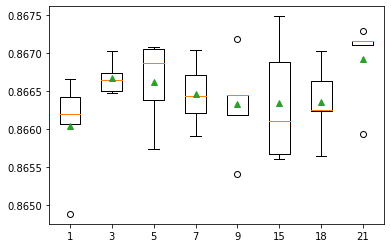

In [190]:
# Um die beste Anzahl an neighbors zu ermittlen, erstellen wir eine Pipeline zur Extraktion der höchsten accuracy 
# bei einem Random Forest Classifier mittles cross-validation
results = list()
n_neighbors = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in n_neighbors:
	# modeling pipeline
	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
	# Cross-Validation 
	cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
	scores = cross_val_score(pipeline, X_train_label_encoded, y_train_label_encoded, scoring='accuracy', cv=cv, n_jobs=-1)
	# Ergebnisse sichern
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, np.mean(scores), np.std(scores)))
# plot model performance
plt.boxplot(results, labels=n_neighbors, showmeans=True)
plt.show()

In [203]:
# Zur dynamischen Übergabe der besten Anzahl an n_neighbors filtern wir diesen aus dem Array n_neighbors, 
# über den Index der Spalte mit dem höchsten Mittelwert

l = []
for row in results:
    means_per_row = np.mean(row)
    l.append(means_per_row)

best_n_neighbors = int(n_neighbors[l.index(np.max(l))])

In [205]:
knn = KNNImputer(n_neighbors=best_n_neighbors, weights='uniform')

# Modellierung auf Trainingsdaten
# Da unser Modell nur mit numerischen Werten umgehen kann, ersetzen wir die kategorialen Werte durch numerische
X_train_df_knn_X = X_train_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1}) 

X_knn_train = knn.fit_transform(X_train_df_knn_X)
X_train_df_knn = pd.DataFrame(X_knn_train, columns=X_train_df_knn_X.columns)
X_train_df_knn['age'] = np.round(X_train_df_knn['age'])

# Modellierung auf Testdaten
X_test_df_knn_X = X_test_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1})

X_knn_test = np.round(knn.fit_transform(X_test_df_knn_X))
X_test_df_knn = pd.DataFrame(X_knn_test, columns=X_test_df_knn_X.columns)
X_test_df_knn['age'] = np.round(X_test_df_knn['age'])

# Nach der Imputation wandeln wir diese wieder zu kategorialen Werten zurück. (Dieser Schritt wäre nicht nötig, allerdings wollen wir bei der ONE-HOT Kodierung wieder die Ausprägung im Variablennamen stehen haben, z.B gender_Female statt gender_0)
X_train_df_knn['gender'] = X_train_df_knn['gender'].round().replace({0: 'Female', 1: 'Male'})
X_test_df_knn['gender'] = X_test_df_knn['gender'].round().replace({0: 'Female', 1: 'Male'})

<AxesSubplot:>

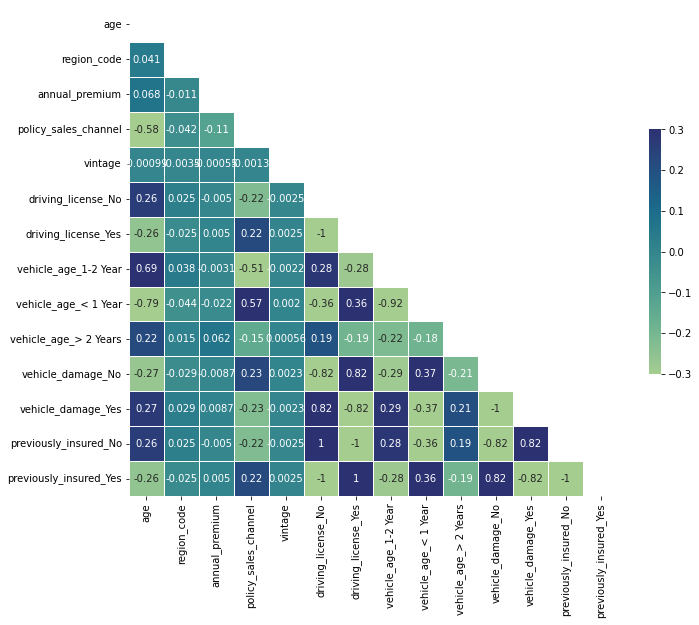

In [206]:
# Create the correlation matrix
corr = X_train_df_knn.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("crest", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

#### Miss Forest

In [207]:
from sklearn.experimental import enable_iterative_imputer

# Modellierung auf den Trainingsdaten
# Diesselbe Herangehensweise bei der Impuation von gender wenden wir auch hier an
X_train_df_mice_X = X_train_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1})

mice_imputer = IterativeImputer()
X_mice = mice_imputer.fit_transform(X_train_df_mice_X)
X_train_df_mice = pd.DataFrame(X_mice, columns=X_train_df_mice_X.columns)
X_train_df_mice['age'] = X_train_df_mice['age'].round()
X_train_df_mice['gender'] = X_train_df_mice['gender'].round().replace({0: 'Female', 1: 'Male'})

# Modellierung auf den Testdaten
X_test_df_mice_X = X_test_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1})

X_mice = mice_imputer.fit_transform(X_test_df_mice_X)
X_test_df_mice = pd.DataFrame(X_mice, columns=X_test_df_mice_X.columns)
X_test_df_mice['age'] = X_test_df_mice['age'].round()
X_test_df_mice['gender'] = X_test_df_mice['gender'].round().replace({0: 'Female', 1: 'Male'})

#### Lineares Regressionsmodell

In [208]:
# Train-Batch Datensatz filtern, nach allen Zeilen mit Missing Values bei Age
X_train_age_na = X_train_df_one_hot_encoded_data_without_gender['age'].isna()
X_train_age_missing = X_train_age_na[X_train_age_na == True]
X_train_age_missing = pd.merge(X_train_age_missing, X_train_df_one_hot_encoded_data_without_gender, left_index=True, right_index=True)
del X_train_age_missing['age_y']
del X_train_age_missing['age_x']

# Test-Batch Datensatz filtern, nach allen Zeilen mit Missing Values bei Age
X_test_age_na = X_test_df_one_hot_encoded_data_without_gender['age'].isna()
X_test_age_missing = X_test_age_na[X_test_age_na == True]
X_test_age_missing = pd.merge(X_test_age_missing, X_test_df_one_hot_encoded_data_without_gender, left_index=True, right_index=True)
del X_test_age_missing['age_y']
del X_test_age_missing['age_x']

# Länge der beiden Data Frames ausgeben lassen
print(len(X_train_age_missing), len(X_test_age_missing))

8637 2204


In [209]:
# Casting für die Training-Batch
X_train_df_one_hot_encoded_data_no_na = X_train_df_one_hot_encoded_data_without_gender.copy().dropna()
X_train_df_one_hot_encoded_data_no_na['annual_premium']= X_train_df_one_hot_encoded_data_no_na['annual_premium'].astype(int)
X_train_df_one_hot_encoded_data_no_na['vintage'] = X_train_df_one_hot_encoded_data_no_na['vintage'].astype(int)
X_train_df_one_hot_encoded_data_no_na['policy_sales_channel'] = X_train_df_one_hot_encoded_data_no_na['policy_sales_channel'].astype(int)
X_train_df_one_hot_encoded_data_no_na['age'] = X_train_df_one_hot_encoded_data_no_na['age'].astype(int)

# Casting für die Testing-Batch
X_test_df_one_hot_encoded_data_no_na = X_test_df_one_hot_encoded_data_without_gender.copy().dropna()
X_test_df_one_hot_encoded_data_no_na['annual_premium']= X_test_df_one_hot_encoded_data_no_na['annual_premium'].astype(int)
X_test_df_one_hot_encoded_data_no_na['vintage'] = X_test_df_one_hot_encoded_data_no_na['vintage'].astype(int)
X_test_df_one_hot_encoded_data_no_na['policy_sales_channel'] = X_test_df_one_hot_encoded_data_no_na['policy_sales_channel'].astype(int)
X_test_df_one_hot_encoded_data_no_na['age'] = X_test_df_one_hot_encoded_data_no_na['age'].astype(int)

# Modell aufbauen
def smf_ols_spec(df): 
    mod = smf.ols(formula = 'age ~ annual_premium + policy_sales_channel + vehicle_damage_No + vehicle_damage_Yes + previously_insured_No + previously_insured_Yes', data=X_train_df_one_hot_encoded_data_no_na)
    return mod

ols_train = smf_ols_spec(X_train_df_one_hot_encoded_data_no_na)
ols_test = smf_ols_spec(X_test_df_one_hot_encoded_data_no_na)

# Modell auf den Trainingsdaten fitten
res_train = ols_train.fit()
res_test = ols_test.fit()

In [210]:
# Resultate für die Training-Batch ausgeben lassen 
print(res_train.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 4.054e+04
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:03:52   Log-Likelihood:            -1.1568e+06
No. Observations:              294166   AIC:                         2.314e+06
Df Residuals:                  294161   BIC:                         2.314e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 27

In [211]:
# Resultate für die Training-Batch ausgeben lassen 
print(res_test.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 4.054e+04
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:03:52   Log-Likelihood:            -1.1568e+06
No. Observations:              294166   AIC:                         2.314e+06
Df Residuals:                  294161   BIC:                         2.314e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 27

In [212]:
# Hier müssen wir die für die Regression verwendeten Variablen nochmal casten, um diese auch im Modell verwenden zu können
X_train_age_missing['annual_premium']= X_train_age_missing['annual_premium'].astype(int)
X_train_age_missing['vintage'] = X_train_age_missing['vintage'].astype(int)
X_train_age_missing['policy_sales_channel'] = X_train_age_missing['policy_sales_channel'].astype(int)

# Predicten 
predictions_age_train_data_ols = pd.DataFrame(round(res_train.predict(X_train_age_missing),2))
predictions_age_train_data_ols.columns = ['age']
predictions_age_train_data_ols

,age
206687,34.19
204901,30.06
204111,30.03
202143,33.67
202708,34.64
...,...
201603,49.65
208676,31.68
206093,39.22
200093,39.26


In [213]:
# Hier müssen wir die für die Regression verwendeten Variablen nochmal casten, um diese auch im Modell verwenden zu können
X_test_age_missing['annual_premium']= X_test_age_missing['annual_premium'].astype(int)
X_test_age_missing['vintage'] = X_test_age_missing['vintage'].astype(int)
X_test_age_missing['policy_sales_channel'] = X_test_age_missing['policy_sales_channel'].astype(int)

# Predicten 
predictions_age_test_data_ols = pd.DataFrame(round(res_test.predict(X_test_age_missing),2))
predictions_age_test_data_ols.columns = ['age']
predictions_age_test_data_ols

,age
210581,54.57
210539,29.96
205529,34.93
201208,33.63
208765,30.27
...,...
205196,39.21
201127,34.18
209353,51.13
207330,29.96


In [214]:
# Training-Batch
X_train_df_regression = pd.merge(X_train_age_missing, predictions_age_train_data_ols, right_index=True, left_index=True)
X_train_df_regression = X_train_df_regression.combine_first(X_train_df_one_hot_encoded_data_without_gender)

# Training-Batch
X_test_df_regression = pd.merge(X_test_age_missing, predictions_age_test_data_ols, right_index=True, left_index=True)
X_test_df_regression = X_test_df_regression.combine_first(X_test_df_one_hot_encoded_data_without_gender)

X_train_df_regression

,age,annual_premium,driving_license_No,driving_license_Yes,gender,policy_sales_channel,previously_insured_No,previously_insured_Yes,region_code,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,vintage
0,44.0,40454,1,0,Male,26,1,0,28.0,0,0,1,0,1,217
1,76.0,33536,1,0,Male,26,1,0,3.0,1,0,0,1,0,183
3,21.0,28619,0,1,Male,152,0,1,11.0,0,1,0,1,0,203
4,29.0,27496,0,1,Female,152,0,1,41.0,0,1,0,1,0,39
5,24.0,2630,1,0,Female,160,1,0,33.0,0,1,0,0,1,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380993,63.0,2630,1,0,Male,124,1,0,28.0,0,0,1,0,1,61
380994,46.0,24758,1,0,Male,26,1,0,28.0,1,0,0,0,1,139
380995,46.0,51660,1,0,Male,124,1,0,28.0,1,0,0,0,1,227
380997,34.0,2630,1,0,Female,124,1,0,41.0,1,0,0,0,1,208


#### Visualisierung der Imputationsverfahren in der Train Batch

In [215]:
# Datensätze erstellen
hist_data_train = [np.array(X_train_df_regression['age'], dtype=np.int64), np.array(X_train_df_mice['age'], dtype=np.int64), np.array(X_train_df_knn['age'], dtype=np.int64), np.array(X_train_mean['age'], dtype=np.int64), np.array(X_train_median['age'], dtype=np.int64), np.array(X_train_original_age['age'], dtype=np.int64)]

# Gruppennamen und Farben festlegen
group_labels = ['train_imputed_regression', 'train_imputed_mice_age','train_imputed_knn_age','train_imputed_mean_age', 'train_imputed_median_age', 'actual_df_age']
colors = ['red','#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Erstellen des Histogrammes 
fig = ff.create_distplot(hist_data_train, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)
fig.update_layout(legend=dict(x=0.893,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Titel hinzufügen
fig.update_layout(title_text='Verteilung der Variable age nach der Imputation in der Train Batch')

# Plot anzeigen
fig.show()

### Visualisierung der Imputationsverfahren auf der Test Batch 

In [216]:
# Datensätze erstellen
hist_data_test = [np.array(X_train_df_regression['age'], dtype=np.int64), np.array(X_test_df_mice['age'], dtype=np.int64), np.array(X_test_df_knn['age'], dtype=np.int64), np.array(X_test_mean['age'], dtype=np.int64), np.array(X_test_median['age'], dtype=np.int64), np.array(X_test_original_age['age'], dtype=np.int64)]

# Gruppennamen und Farben festlegen
group_labels = ['test_imputed_ols_age','test_imputed_mice_age','test_imputed_knn_age','test_imputed_mean_age', 'test_imputed_median_age', 'actual_df_age']
colors = ['red', '#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Erstellen des Histogrammes 
fig = ff.create_distplot(hist_data_test, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)
fig.update_layout(legend=dict(x=0.895,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Titel hinzufügen
fig.update_layout(title_text='Verteilung der Variable age nach der Imputation in der Test Batch')

# Plot anzeigen
fig.show()

### Visualisierung der Impuation von gender

In [246]:
print(f"Before Imputation: \n{X_train_df['gender'].value_counts(normalize=True)}")
print('\n')
print(f"After KNN Imputation: \n{X_train_df_knn['gender'].value_counts(normalize=True)}")
print('\n')
print(f"After MICE Imputation: \n{X_train_df_mice['gender'].value_counts(normalize=True)}")

Before Imputation: 
Male      0.540662
Female    0.459338
Name: gender, dtype: float64


After KNN Imputation: 
Male      0.540871
Female    0.459129
Name: gender, dtype: float64


After MICE Imputation: 
Male      0.540736
Female    0.459264
Name: gender, dtype: float64


Hier wenden wir die ONE-HOT Kodierung wieder auf `gender` an und entscheiden uns sowohl bei der Imputation von `age` als auch von `gender` für die Ergebnisse der Imputation vom `KNNImputer`, da diese der uprünglichen Verteilung in den jeweiligen Variablen am Nächsten sind. 

In [239]:
X_train_df_final = pd.get_dummies(X_train_df_knn, columns = ['gender'])

X_test_df_final = pd.get_dummies(X_test_df_knn, columns = ['gender'])

X_train_df_final['age'].unique()

array([45.        , 25.        , 42.        , 35.        , 26.        ,
       24.        , 41.        , 30.        , 68.        , 71.        ,
       20.        , 26.66666667, 34.        , 37.        , 77.        ,
       32.        , 21.        , 25.66666667, 66.        , 36.        ,
       52.        , 44.        , 51.        , 61.        , 55.        ,
       43.        , 28.        , 22.        , 27.52380952, 23.        ,
       62.        , 59.        , 40.        , 38.        , 31.        ,
       56.        , 50.        , 27.        , 57.        , 29.71428571,
       54.        , 65.        , 58.        , 76.        , 46.        ,
       78.        , 47.        , 39.        , 33.        , 64.        ,
       49.        , 72.        , 48.        , 27.33333333, 69.        ,
       49.95238095, 25.28571429, 53.        , 50.14285714, 54.9047619 ,
       74.        , 45.47619048, 26.85714286, 75.        , 25.04761905,
       73.        , 29.        , 67.        , 63.        , 43.80

## Sampling

#### Oversampling

In [219]:
X_train_df_os = pd.concat([X_train_df_final , y_train_df],axis=1)

response_no = X_train_df_os[X_train_df_os['response'] == 'no']
response_yes = X_train_df_os[X_train_df_os['response'] == 'yes']

# upsample minority
response_upsampled = resample(response_yes,
                          replace=True, # sample with replacement
                          n_samples=len(response_no), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([response_no, response_upsampled])

# check new class counts
upsampled.response.value_counts()

no     266381
yes    266381
Name: response, dtype: int64

In [220]:
df_upsampled_response = upsampled.groupby(['response']).size().reset_index()
fig = px.bar(df_upsampled_response, x='response', y=upsampled['response'].value_counts(normalize=False), color='response',
                                    text=upsampled['response'].value_counts(normalize=False),
                                    color_discrete_map={
                                        'yes': 'rgb(18,116,117)',
                                        'no': 'rgb(20,29,67)'
                                    })

fig.update_layout(title='Relative Verteilung der Ausprägungen von Response nach dem Upsampling',
                 xaxis_title='Response',
                 yaxis_title='Count')
fig.show()

#### Undersampling mit einem einfachen Modell evaluieren 

In [221]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersample = RandomUnderSampler(sampling_strategy='auto')

# Undersampling anwenden
X_train_under, y_train_under = undersample.fit_resample(X_train_df_final, y_train_label_encoded['response'])
X_test_under, y_test_under = undersample.fit_resample(X_test_df_final, y_test_label_encoded['response'])

# Verteilung von train
print("Before undersampling train: ", Counter(y_train_label_encoded['response']))
print("After undersampling train: ", Counter(y_train_under))

print('-'*60)
# Verteilung von test
print("Before undersampling test: ", Counter(y_test_label_encoded['response']))
print("After undersampling test: ", Counter(y_test_under))

Before undersampling train:  Counter({0: 266381, 1: 37207})
After undersampling train:  Counter({0: 37207, 1: 37207})
------------------------------------------------------------
Before undersampling test:  Counter({0: 66529, 1: 9369})
After undersampling test:  Counter({0: 9369, 1: 9369})


In [222]:
X_test_under.head()

,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,gender_Female,gender_Male
0,79.0,46.0,43853.0,124.0,117.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1
1,58.0,46.0,33466.0,26.0,107.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1
2,22.0,6.0,17863.0,152.0,26.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0
3,60.0,28.0,45396.0,124.0,125.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1
4,78.0,5.0,31886.0,124.0,149.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1


#### Oversampling \w SMOTE

SMOTE (Synthetic Minority Oversampling Technique) besteht darin, Elemente für die minority class zu synthetisieren, die auf den bereits vorhandenen Elementen basieren. Dabei wird nach dem Zufallsprinzip eine Zeile aus der minority class ausgewählt und die k-nearest neighbors für dessen Daten berechnet. Die synthetischen Daten werden zwischen dem ausgewählten Zeile und deren Nachbarn eingefügt.

In [223]:
# Pipeline für die Crossvalidierung
pipeline = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='auto' ,random_state=11, n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

# Splitting des Datensatzes
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

# Grid Search mit Parametertuning durchführen
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)


# Modell fitten
grid_search.fit(X_train_df_final, y_train_df['response'])

# Besten Paramter ausgeben
print(grid_search.best_params_)

# Modell testen
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_df_final, y_test_df['response'])
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

{'classifier__C': 100}
Cross-validation score: 0.8335733550133206
Test score: 0.8335161403848097


In [224]:
smote = SMOTE()

# Oversampling durchführen
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_df_final, y_train_label_encoded['response'])
X_test_SMOTE, y_test_SMOTE = smote.fit_resample(X_test_df_final, y_test_label_encoded['response'])

#### Entscheidung für Over- oder Undersampling

Um uns für ein Samplingverfahren zu entscheiden, wenden wir bei beiden Verfahren einen unangepassten `Random Forest Classifier` an, um uns anhand der Modellgüte einen Eindruck zu verschaffen, ob das Over - bzw. Undersampling an Over - oder Underfitting leidet und wie gut bzw. schlecht die Perfomance der Datensätze, auf Grundlage der beiden Samplingverfahren ist. 

Oversampling

In [225]:
from sklearn.metrics import confusion_matrix, roc_curve

# Modell für den Random Forest instanzieren
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

# Modell fitten
rfc.fit(X_train_SMOTE, y_train_SMOTE)

# absolute und relative Vorhersagen
res = rfc.predict(X_test_SMOTE)
resa = rfc.predict_proba(X_test_SMOTE)[:,1]

# False Positive, True Postive Rate bestimmen
fpr, tpr, _ = roc_curve(y_test_SMOTE, resa)

# Fläche unter der False Positive, True Postive Rate berechnen
roc_auc = roc_auc_score(y_test_SMOTE, resa)

# Area Plot erstellen
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={np.round(roc_auc, 4)})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# Linie des Zufallsmodelles einfügen
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

# Skalierung anpassen
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

# Plot anzeigen
fig.show()

Undersampling

In [226]:
# Modell für den Random Forest instanzieren
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

# Modell fitten
rfc.fit(X_train_under, y_train_under)

# absolute und relative Vorhersagen
res = rfc.predict(X_test_under)
resa = rfc.predict_proba(X_test_under)[:,1]

# False Positive, True Postive Rate bestimmen
fpr, tpr, _ = roc_curve(y_test_under, resa)

# Fläche unter der False Positive, True Postive Rate berechnen
roc_auc = roc_auc_score(y_test_under, resa)

# Area Plot erstellen
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={np.round(roc_auc, 4)})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# Linie des Zufallsmodelles einfügen
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

# Skalierung anpassen
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

# Plot anzeigen
fig.show()

Aufgrund des sehr hohen ROC AUC beim Oversampling, gehen wir davon aus, dass unser synthetisches Oversampling mittels `SMOTE` starkes Overfitting aufweist. Wahrscheinlich würde der `RandomOverSampler` weniger abhängige Werte erzeugen, da wir allerings beim Undersampling auch einen hohen ROC AUC berechnen konnten, entscheiden wir uns lieber für den Verlust an Daten, als den Informationsausstausch beim Oversampling.  

## Feature Engineering 

Da wir vorwiegend kategoriale Variablen im Datensatz vorfinden, sehen wir die Möglichkeit der Generierung von neuen Features als eingeschränkt an. Wir kombinieren lediglich die metrischen Varialen `annual_premium` und `vintage` zu neuen Variablen und nehmen ein Binning bei `age` vor. 

In [227]:
from feature_engine.creation import MathematicalCombination
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler

arithmetische Kombination aus den metrischen Variablen `annual_premium` und `vintage`

In [228]:
combinator = MathematicalCombination(
    variables_to_combine=['annual_premium', 'vintage'],
    math_operations=['mean', 'prod', 'sum', 'std'],
    new_variables_names=['mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']
)

X_train_df_fe = combinator.fit_transform(X_train_df_final, y_train)
X_test_df_fe = combinator.fit_transform(X_test_df_final, y_test)

X_train_df_fe.loc[:, ['annual_premium', 'vintage', 'mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']].head()

,annual_premium,vintage,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage
0,30029.0,192.0,15110.5,5765568.0,30221.0,21097.945030
1,32353.0,32.0,16192.5,1035296.0,32385.0,22854.398275
2,24839.0,106.0,12472.5,2632934.0,24945.0,17488.872019
3,26574.0,101.0,13337.5,2683974.0,26675.0,18719.237818
4,24010.0,203.0,12106.5,4874030.0,24213.0,16834.091140


Binning bei der Variable `age` erstellen

In [229]:
X_train_df_fe['age_bin'] = pd.cut(X_train_df_fe['age'], bins=[19, 40, 60, 80, 100], labels=['20-40','40-60','60-80','80-100'])
X_test_df_fe['age_bin'] = pd.cut(X_test_df_fe['age'], bins=[19, 40, 60, 80, 100], labels=['20-40','40-60','60-80','80-100'])

LE = LabelEncoder()

# Kategoriale Ausprägung von age_bin in numerische Katgorien umwandeln -> Korrelation, Modelling
X_train_df_fe['age_bin'] = LE.fit_transform(X_train_df_fe['age_bin'])
X_test_df_fe['age_bin'] = LE.fit_transform(X_test_df_fe['age_bin'])

Standard scaling removes mean and scale data to unit variance.

In [230]:
standart_scaler = StandardScaler()
X_train_df_fe['annual_premium_scaled'] = standart_scaler.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_scaled'] = standart_scaler.fit_transform(X_test_df_fe[['annual_premium']])


print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_scaled'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_scaled'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_scaled'].std())

Train-Batch
Mean: 6.166004049435366e-17
Standard Deviation: 1.000001646972987
Test-Batch
Mean: 2.3217291426454563e-17
Standard Deviation: 1.0000065878539737


Min Max Skalierung - skaliert alle Ausprägungen auf Werte zwischen 0 und 1 

In [231]:
minmax_scaler = MinMaxScaler()

X_train_df_fe['annual_premium_min_max_scaled'] = minmax_scaler.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_min_max_scaled'] = minmax_scaler.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_min_max_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_min_max_scaled'].std())

print('Test-Batch')
print('Mean:', X_train_df_fe['annual_premium_min_max_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_min_max_scaled'].std())

Train-Batch
Mean: 0.05197356885256225
Standard Deviation: 0.03202602486336479
Test-Batch
Mean: 0.05197356885256225
Standard Deviation: 0.03202602486336479


Quantil Transformation - uniforme Verteilung in der Variable

In [232]:
qtrans = QuantileTransformer()

X_train_df_fe['annual_premium_q_trans_uniform'] = qtrans.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_q_trans_uniform'] = qtrans.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_q_trans_uniform'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_uniform'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_q_trans_uniform'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_q_trans_uniform'].std())

Train-Batch
Mean: 0.4862572679630686
Standard Deviation: 0.30995856227982704
Test-Batch
Mean: 0.4854736188051926
Standard Deviation: 0.30983639312736233


Quantil Transformation - normale Verteilung in der Variable

In [233]:
qtrans_normal = QuantileTransformer(output_distribution='normal', random_state=42)

X_train_df_fe['annual_premium_q_trans_normal'] = qtrans_normal.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_q_trans_normal'] = qtrans_normal.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_q_trans_normal'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_normal'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_q_trans_normal'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_q_trans_normal'].std())

Train-Batch
Mean: -0.6345155680381955
Standard Deviation: 2.1873237155506717
Test-Batch
Mean: -0.6328966692290567
Standard Deviation: 2.1894983608209317


In [234]:
# Korrelationsplot erstellen
corr = X_train_df_fe.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap="crest", axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\aster\AppData\Local\Temp/ipykernel_41036/3001735163.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,gender_Female,gender_Male,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
region_code,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_premium,0.07,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
policy_sales_channel,-0.58,-0.04,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vintage,-0.00,-0.00,-0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_No,0.26,0.03,-0.01,-0.22,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_Yes,-0.26,-0.03,0.01,0.22,0.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_1-2 Year,0.69,0.04,-0.00,-0.51,-0.00,0.28,-0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_< 1 Year,-0.79,-0.04,-0.02,0.57,0.00,-0.36,0.36,-0.92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_> 2 Years,0.22,0.02,0.06,-0.15,0.00,0.19,-0.19,-0.22,-0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [235]:
# Korrelationsplot erstellen
corr = X_test_df_fe.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap="crest", axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\aster\AppData\Local\Temp/ipykernel_41036/4252982992.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,gender_Female,gender_Male,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
region_code,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_premium,0.06,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
policy_sales_channel,-0.58,-0.04,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vintage,-0.00,0.00,-0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_No,0.26,0.02,-0.00,-0.22,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_Yes,-0.26,-0.02,0.00,0.22,0.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_1-2 Year,0.69,0.04,-0.00,-0.51,-0.00,0.28,-0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_< 1 Year,-0.78,-0.04,-0.02,0.57,0.00,-0.36,0.36,-0.92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_> 2 Years,0.22,0.01,0.06,-0.15,0.00,0.19,-0.19,-0.22,-0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


#### Bewertung des Feature Engineerings mittels Logistischer Regression 

In [236]:
# Modell für die logistische Regression instanzieren
lrg = LogisticRegression(random_state=11, max_iter=1000)

# Splitting vornehmen
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

# Grid Search mit Parametertuning durchführen
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = RandomizedSearchCV(estimator=lrg,
                           param_distributions=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)


# Modell fitten
lrg_model = grid_search.fit(X_train_df_fe, y_train_df['response'])

print(lrg_model.best_params_)

cv_score = lrg_model.best_score_

# absolute und relative Vorhersagen treffen
y_pred = lrg_model.predict(X_test_df_fe)
y_pred_proba = lrg_model.predict_proba(X_test_df_fe)[:,1]
print(f'Cross-validation score: {cv_score}')

c:\Users\aster\Documents_\Hochschule\Data Analysis Hausarbeit\Hausarbeit\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.



{'C': 0.1}
Cross-validation score: 0.5530761065807644


In [237]:
# False Positive, True Postive Rate bestimmen
fpr, tpr, _ = roc_curve(y_test_label_encoded['response'], y_pred_proba)

# Fläche unter der False Positive, True Postive Rate berechnen
auc_score = roc_auc_score(y_test_label_encoded['response'], y_pred_proba)

# Area Plot erstellen
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# Linie des Zufallsmodelles einfügen
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

# Skalierung anpassen
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

# Plot erstellen
fig.show()

Aufgrund der niedrigen Korellation zwischen den, von uns neu generierten Variablen und den ursprünglichen, gehen wir nicht davon aus, dass diese unsere Daten besser beschreiben können und einen Mehrwert beim Modelling darstellen. Die gleiche Aussage lässt sich nach der Auswerung der logistischen Regression treffen, da sich der ROC AUC unterhalb der Kurve des Zufallsmodelles befindet. Daher haben wir uns dazu entschieden, keine neuen Features in den Trainingsdatensatz aufzunehmen. 

Exportieren der finalen Trains - und Testdaten als csv Dateien

In [238]:
X_train_under.to_csv('../data/x_train_clean.csv', sep="$", decimal=".")
y_train_under.to_csv('../data/y_train_clean.csv', sep="$", decimal=".")

X_test_under.to_csv('../data/x_test_clean.csv', sep="$", decimal=".")
y_test_under.to_csv('../data/y_test_clean.csv', sep="$", decimal=".")